In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp
from sklearn.model_selection import train_test_split

from layer_flow.data import DatasetFactory
from layer_flow.clustering.kmpp import kmpp
from layer_flow.network import Network, accuracy

In [ ]:
seed = 1
# x, y = make_circles(n_samples=100, random_state=seed)
ds = DatasetFactory.create('moons', n=100, noise=0.1, random_state=seed)
x, y = ds.X, ds.y[:, 0]
k = 5
centroids = kmpp(x, k, seed)

In [3]:
def plot(x, y, centroids=None, decision_boundary=None):
    plt.figure(figsize=(4, 4))
    for class_index in np.unique(y):
        plt.scatter(x[y == class_index, 0], x[y == class_index, 1], label=f'Class {class_index}')
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroids')
    if decision_boundary is not None:
        plt.contourf(decision_boundary[0], decision_boundary[1], decision_boundary[2], alpha=0.2, cmap='coolwarm', zorder=-1)
    plt.title('K-means++ Initialization on Moons Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    ax = plt.gca()
    ax.set_axisbelow(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

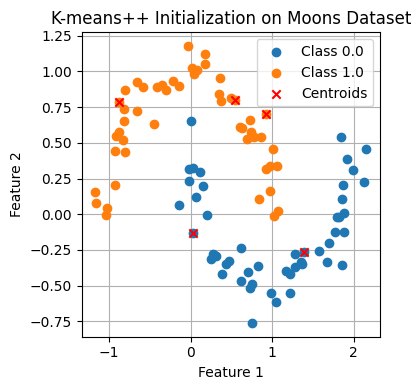

In [4]:
plot(x, y, centroids=centroids)

## Landmark Weight Initialization
This section explores the convergence and performance of models initialized with landmark weights. We use an architecture of widths $\text{in-dim}\rightarrow k\rightarrow k\rightarrow \text{out-dim}$, where $k$ is the number of landmarks. This architecture requires 3 weight matrices which are initialized using the landmark matrix $L\in\mathbb{R}^{\text{in-dim}\times k}$ and randomly initialized matrices $D_1\in\mathbb{R}^{k\times k}$ and $D_2\in\mathbb{R}^{k\times \text{out-dim}}$.
- Layer 1: $W_1 = L D_1$
- Layer 2: $W_2 = L^T L$
- Layer 3: $W_3 = D_2$

In [ ]:
def get_weights(x, y, k, seed=seed):
    centroids = kmpp(x, k, seed, verbose=True)
    out_dim = y.shape[1]
    L = centroids.T
    D_1 = np.random.normal(size=(k, k))
    D_2 = np.random.normal(size=(k, out_dim))


    W_1 = L @ D_1 # (d, k)
    W_2 = L.T @ L # (k, k)
    W_3 = D_2 # (k, out_dim)

    W_1 = ((W_1.flatten() - W_1.flatten().mean()) / W_1.flatten().std()).reshape(W_1.shape)
    W_2 = ((W_2.flatten() - W_2.flatten().mean()) / W_2.flatten().std()).reshape(W_2.shape)
    W_3 = ((W_3.flatten() - W_3.flatten().mean()) / W_3.flatten().std()).reshape(W_3.shape)
    return W_1, W_2, W_3

In [ ]:
seed = int(time.time())

ds = DatasetFactory.create('mnist')
x, y = ds.X, ds.y

k = 100
hidden_dim = 100

x_train, x_val, y_train, y_val = ds.X_train, ds.X_val, ds.y_train, ds.y_val

W_1, W_2, W_3 = get_weights(x_train, y_train, k, seed)

b_1, b_2, b_3 = jnp.zeros((k,)), jnp.zeros((k,)), jnp.zeros((10,))
parameters = [(W_1, b_1), (W_2, b_2), (W_3, b_3)]

  0%|          | 0/99 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

Train accuracy with landmarks: 0.10483887046575546
Validation accuracy with landmarks: 0.10557142645120621
Train accuracy with random weights: 0.10587970912456512
Validation accuracy with random weights: 0.10885713994503021


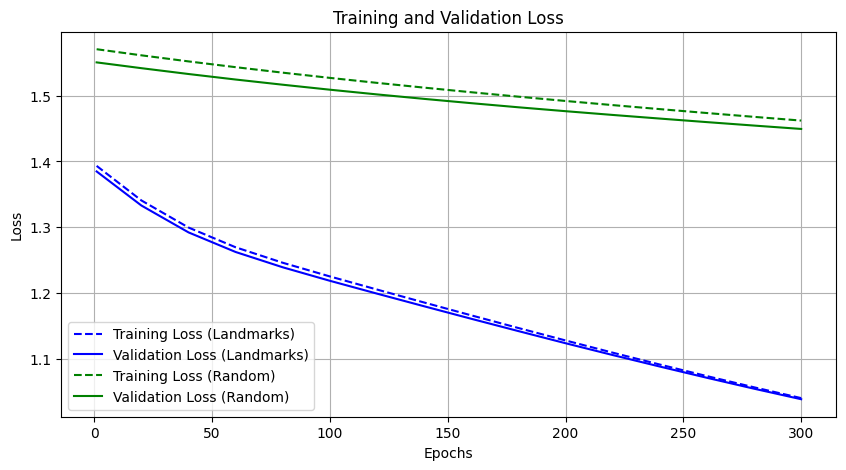

"\ngranularity = 1000\nx1 = jnp.linspace(-1.5, 2.5, granularity)\nx2 = jnp.linspace(-1.5, 2.5, granularity)\nxx1, xx2 = jnp.meshgrid(x1, x2)\nx_grid = jnp.c_[xx1.ravel(), xx2.ravel()]\ny_grid = model_land(x_grid)[:, 1]\ny_grid = y_grid.reshape(xx1.shape)\nplt.figure(figsize=(10, 5))\nplt.contourf(xx1, xx2, y_grid, levels=50, cmap='RdBu', alpha=0.5)\nplt.scatter(x_train[:, 0], x_train[:, 1], c='blue', label='Train')\nplt.scatter(x_val[:, 0], x_val[:, 1], c='orange', label='Validation')\nplt.scatter(x[y[:, 0] == 1, 0], x[y[:, 0] == 1, 1],\n                c='red', label='Class 1', alpha=0.5)\nplt.scatter(x[y[:, 1] == 1, 0], x[y[:, 1] == 1, 1],\n                c='green', label='Class 2', alpha=0.5)\nplt.title('Decision Boundary and Data Points')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid()\nplt.show()\n"

In [11]:
b_1, b_2, b_3 = jnp.zeros((k,)), jnp.zeros((k,)), jnp.zeros((10,))
parameters = [(W_1, b_1), (W_2.T, b_2), (W_3, b_3)]
model_land = Network(parameters)

model_rand = Network()
model_rand.initialize([784, hidden_dim, hidden_dim, 10], seed=seed)

losses_land, val_losses_land = model_land.train(x_train, y_train, x_val, y_val,
                lr=0.01, epochs=300, log_every=20)
losses_rand, val_losses_rand = model_rand.train(x_train, y_train, x_val, y_val,
                lr=0.01, epochs=300, log_every=20)
    
print(f"Train accuracy with landmarks: {accuracy(model_land, x_train, y_train)}")
print(f"Validation accuracy with landmarks: {accuracy(model_land, x_val, y_val)}")

print(f"Train accuracy with random weights: {accuracy(model_rand, x_train, y_train)}")
print(f"Validation accuracy with random weights: {accuracy(model_rand, x_val, y_val)}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(list(losses_land.keys()), list(
    losses_land.values()), label='Training Loss (Landmarks)', color='blue', linestyle='--')
plt.plot(list(val_losses_land.keys()), list(
        val_losses_land.values()), label='Validation Loss (Landmarks)', color='blue')
plt.plot(list(losses_rand.keys()), list(
    losses_rand.values()), label='Training Loss (Random)', color='green', linestyle='--')
plt.plot(list(val_losses_rand.keys()), list(
        val_losses_rand.values()), label='Validation Loss (Random)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Draw samples and decision boundary
"""
granularity = 1000
x1 = jnp.linspace(-1.5, 2.5, granularity)
x2 = jnp.linspace(-1.5, 2.5, granularity)
xx1, xx2 = jnp.meshgrid(x1, x2)
x_grid = jnp.c_[xx1.ravel(), xx2.ravel()]
y_grid = model_land(x_grid)[:, 1]
y_grid = y_grid.reshape(xx1.shape)
plt.figure(figsize=(10, 5))
plt.contourf(xx1, xx2, y_grid, levels=50, cmap='RdBu', alpha=0.5)
plt.scatter(x_train[:, 0], x_train[:, 1], c='blue', label='Train')
plt.scatter(x_val[:, 0], x_val[:, 1], c='orange', label='Validation')
plt.scatter(x[y[:, 0] == 1, 0], x[y[:, 0] == 1, 1],
                c='red', label='Class 1', alpha=0.5)
plt.scatter(x[y[:, 1] == 1, 0], x[y[:, 1] == 1, 1],
                c='green', label='Class 2', alpha=0.5)
plt.title('Decision Boundary and Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()
"""

## Landmark Data Transformation
This section explores the effect of transforming the data using the landmark matrix $L$ before training. The data transformation is defined as $X' = L^T X$, where $X\in\mathbb{R}^{2\times n}$ is the input data and $X'\in\mathbb{R}^{k\times n}$ is the transformed data. The model is trained on the transformed data using the same architecture as before.

In [ ]:
seed = int(time.time())
k = 784
hidden_dim = 100

ds = DatasetFactory.create('mnist')
x, y = ds.X, ds.y

x_train, x_val, y_train, y_val = ds.X_train, ds.X_val, ds.y_train, ds.y_val

print("Looking for landmarks...")
centroids = kmpp(x_train, k, seed)
print("Landmarks found.")
x_train_prime = x_train @ centroids.T
x_val_prime = x_val @ centroids.T

Looking for landmarks...
Landmarks found.


Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training:   0%|          | 0/300 [00:00<?, ?epoch/s]

Train accuracy with landmarks: 0.4240698516368866
Validation accuracy with landmarks: 0.41342857480049133
Train accuracy with random weights: 0.2759239971637726
Validation accuracy with random weights: 0.2784285545349121


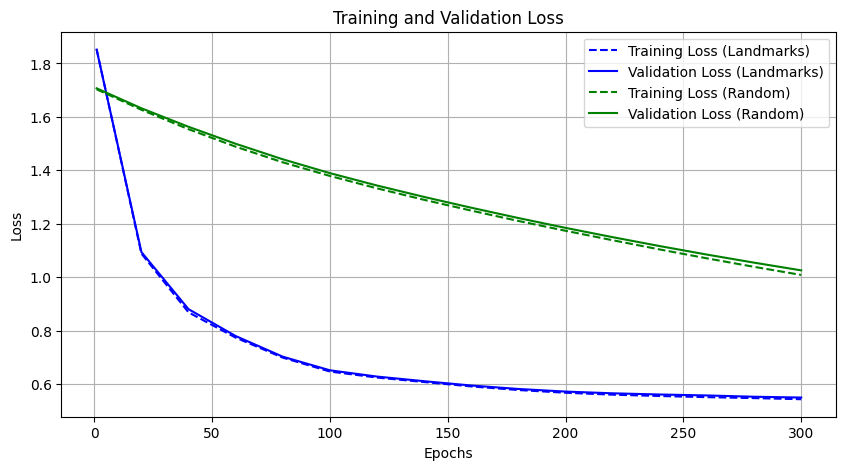

"\ngranularity = 1000\nx1 = jnp.linspace(-1.5, 2.5, granularity)\nx2 = jnp.linspace(-1.5, 2.5, granularity)\nxx1, xx2 = jnp.meshgrid(x1, x2)\nx_grid = jnp.c_[xx1.ravel(), xx2.ravel()] @ centroids.T\ny_grid = model_land(x_grid)[:, 1]\ny_grid = y_grid.reshape(xx1.shape)\nplt.figure(figsize=(10, 5))\nplt.contourf(xx1, xx2, y_grid, levels=50, cmap='RdBu', alpha=0.5)\nplt.scatter(x_train[:, 0], x_train[:, 1], c='blue', label='Train')\nplt.scatter(x_val[:, 0], x_val[:, 1], c='orange', label='Validation')\nplt.scatter(x[y[:, 0] == 1, 0], x[y[:, 0] == 1, 1],\n                c='red', label='Class 1', alpha=0.5)\nplt.scatter(x[y[:, 1] == 1, 0], x[y[:, 1] == 1, 1],\n                c='green', label='Class 2', alpha=0.5)\nplt.title('Decision Boundary and Data Points')\nplt.xlabel('Feature 1')\nplt.ylabel('Feature 2')\nplt.legend()\nplt.grid()\nplt.show()\n"

In [33]:
model_land = Network()
model_land.initialize([k, hidden_dim, hidden_dim, 10], seed)

model_rand = Network()
model_rand.initialize([784, hidden_dim, hidden_dim, 10], seed)

losses_land, val_losses_land = model_land.train(x_train_prime, y_train, x_val_prime, y_val,
                lr=0.1, epochs=300, log_every=20)
losses_rand, val_losses_rand = model_rand.train(x_train, y_train, x_val, y_val,
                lr=0.1, epochs=300, log_every=20)
    
print(f"Train accuracy with landmarks: {accuracy(model_land, x_train_prime, y_train)}")
print(f"Validation accuracy with landmarks: {accuracy(model_land, x_val_prime, y_val)}")

print(f"Train accuracy with random weights: {accuracy(model_rand, x_train, y_train)}")
print(f"Validation accuracy with random weights: {accuracy(model_rand, x_val, y_val)}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(list(losses_land.keys()), list(
    losses_land.values()), label='Training Loss (Landmarks)', color='blue', linestyle='--')
plt.plot(list(val_losses_land.keys()), list(
        val_losses_land.values()), label='Validation Loss (Landmarks)', color='blue')
plt.plot(list(losses_rand.keys()), list(
    losses_rand.values()), label='Training Loss (Random)', color='green', linestyle='--')
plt.plot(list(val_losses_rand.keys()), list(
        val_losses_rand.values()), label='Validation Loss (Random)', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Draw samples and decision boundary
"""
granularity = 1000
x1 = jnp.linspace(-1.5, 2.5, granularity)
x2 = jnp.linspace(-1.5, 2.5, granularity)
xx1, xx2 = jnp.meshgrid(x1, x2)
x_grid = jnp.c_[xx1.ravel(), xx2.ravel()] @ centroids.T
y_grid = model_land(x_grid)[:, 1]
y_grid = y_grid.reshape(xx1.shape)
plt.figure(figsize=(10, 5))
plt.contourf(xx1, xx2, y_grid, levels=50, cmap='RdBu', alpha=0.5)
plt.scatter(x_train[:, 0], x_train[:, 1], c='blue', label='Train')
plt.scatter(x_val[:, 0], x_val[:, 1], c='orange', label='Validation')
plt.scatter(x[y[:, 0] == 1, 0], x[y[:, 0] == 1, 1],
                c='red', label='Class 1', alpha=0.5)
plt.scatter(x[y[:, 1] == 1, 0], x[y[:, 1] == 1, 1],
                c='green', label='Class 2', alpha=0.5)
plt.title('Decision Boundary and Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid()
plt.show()
"""